## IMPORT PACKAGES

In [1]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
import pickle

sys.path.append('../../')
from utils import microarray_utils, clustering_utils, bokeh_ui_utils, file_utils

In [2]:
full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')
full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})
num_genes = full_filtered_df.shape[0]
num_genes

19152

In [3]:
full_filtered_df.sample(10)

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
10399,TTHERM_00670620,5.831024,5.737165,5.224148,7.195567,6.660725,5.659107,7.094234,5.936377,5.628463,...,8.356629,8.283766,8.421192,8.797771,8.012071,8.498364,8.089819,8.369089,7.960086,7.767347
7902,TTHERM_00474739,8.638453,8.959126,8.844551,8.682898,9.250770,9.014108,8.275088,8.282150,8.618717,...,8.859514,9.312102,9.062897,8.804116,8.856254,8.779394,9.630607,8.987066,8.657291,9.122779
5912,TTHERM_00332180,4.772392,5.428036,5.378430,5.067249,5.538471,5.252264,5.187315,5.439229,5.449491,...,9.521656,8.190086,8.596116,8.212507,9.140870,8.811838,8.709603,9.282577,8.905670,9.312261
8694,TTHERM_00530400,7.353662,7.388652,6.841847,8.024569,7.422395,7.439709,7.825297,7.808882,7.814057,...,9.171823,9.248850,8.786007,9.710825,10.429136,9.820894,10.010100,10.371550,9.982339,10.910580
8703,TTHERM_00530550,12.140635,11.957836,12.205855,12.026756,11.855542,12.093753,11.998277,11.600180,12.069407,...,10.679239,9.445916,10.154074,9.632286,9.364465,9.484726,9.362584,10.430788,9.956856,9.089871
1373,TTHERM_000494689,8.125013,6.432695,7.499338,8.458559,6.975076,7.160774,9.029235,6.737293,7.599972,...,10.053776,10.185564,10.390214,9.566559,10.316188,10.504268,9.731294,10.662005,10.514324,10.021161
8771,TTHERM_00532680,11.217164,10.447262,11.074482,10.991777,10.535440,11.216375,10.873872,10.044041,10.578648,...,12.100417,12.420951,12.539069,12.049983,11.728118,11.758224,11.222703,11.806621,11.979040,11.366005
10171,TTHERM_00655450,8.355133,7.697232,7.839855,8.085652,7.419765,7.760282,8.145202,7.627479,8.044066,...,7.852704,8.358295,8.411185,8.525191,7.729347,7.890940,7.892694,7.528949,7.918582,8.450652
9055,TTHERM_00558420,5.174808,5.102157,4.838999,5.176295,4.800589,5.175938,5.009481,5.346431,5.596640,...,5.075883,4.874629,5.066609,4.721515,4.572923,4.642882,4.631997,4.937713,4.785348,4.723967
11653,TTHERM_00794160,6.969044,7.268110,6.978732,7.481524,7.469839,7.229787,7.328501,7.505887,7.322460,...,8.537651,7.902411,8.085239,8.314812,8.464247,8.729935,8.058989,8.759884,8.920288,8.404975


In [4]:
full_filtered_norm_df = microarray_utils.normalize_expression_per_gene(full_filtered_df, z=True)

In [5]:
# import numpy as np
# import scipy.stats as st

# def normalizer(array):
#     """
#     Normalizes the values of an array to range from zero to one
#     """
    
#     a = np.array(array)
    
#     normalized = (array - np.min(array)) / (np.max(array) - np.min(array))
    
#     return normalized


# def z_normalizer(array):

#     """
#     Normalizes the values of an array to z-score from mean
#     """

#     # log_a = [np.log10(expr) for expr in array]
#     normalized = pd.Series(st.zscore(array))
#     return normalized


# def normalize_expression_per_gene(expression_df, z=False):
#     """
#     Function to normalize all gene expression to range from zero to one.
#     """
#     if 'TTHERM_ID' in expression_df.columns:
#         ttids = expression_df['TTHERM_ID'].values
#         data = expression_df[list(expression_df.columns)[1:]]

#         columns = expression_df.columns.tolist()

#         if z:
#             norm_expression_df = data.apply(lambda row: z_normalizer(row), axis=1)
#             norm_expression_df.columns = columns[1:]
        
#         else:
#             norm_expression_df = data.apply(lambda row: normalizer(row), axis=1)
        
#         norm_expression_df['TTHERM_ID'] = ttids
#         # norm_expression_df.columns = columns
        
        
#         columns = norm_expression_df.columns.tolist()
        
#         rearrangment = columns[-1:] + columns[:-1]
        
#         norm_expression_df = norm_expression_df[rearrangment]
        
#     else:

#         if z:
#             norm_expression_df = data.apply(lambda row: z_normalizer(row), axis=1)
#             norm_expression_df.columns = columns

#         else:
#             norm_expression_df = expression_df.apply(lambda row: normalizer(row), axis=1)
    
#     return norm_expression_df

In [6]:
# expression_df = full_filtered_df
# data = expression_df[list(expression_df.columns)[1:]]
# ttids = expression_df['TTHERM_ID'].values
# columns = expression_df.columns.tolist()

In [7]:
# normalize_expression_per_gene(full_filtered_df, z=True)

In [8]:
# columns

In [9]:
# data.apply(lambda row: normalizer(row), axis=1)

In [10]:
# data.apply(lambda row: z_normalizer(row), axis=1)

In [11]:
# import numpy as np
# import scipy.stats as st

# def get_arith_mean_expression(expression_df):
#     """
#     Function to take an expression dataframe from the microarrays and collapse it into the means of
#     all replicate chips.
#     """
#     # C2 and S12 got removed during quality control
#     x = [
#         'Ll', 
#         'Lm', 
#         'Lh', 
#         'S0', 
#         'S3', 
#         'S6', 
#         'S9', 
#         # 'S12', 
#         'S15', 
#         'S24', 
#         'C0', 
#         # 'C2', 
#         'C4', 
#         'C6', 
#         'C8', 
#         'C10', 
#         'C12', 
#         'C14', 
#         'C16', 
#         'C18']
    
#     # cols = expression_df.columns[1:]
#     # x = [c for c in x if c in cols]
    
#     condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}
    
#     for c in list(expression_df.columns)[1:]:
        
#         cond = c.split('_')[0]
#         if cond in condition_expr_dict.keys():
#             expr_list = condition_expr_dict.get(cond, [])

#             # Need to avoid true zeros
#             expr_list.append(expression_df[c].values)
#             condition_expr_dict[cond] = expr_list
        
#     condition_mean_dict = {c: np.mean(np.array(condition_expr_dict[c]), axis=0) for c in condition_expr_dict.keys() if c in x}
    
#     mean_expr_df = pd.DataFrame(condition_mean_dict)
#     mean_expr_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
#     cols = list(mean_expr_df.columns)
#     reorder = cols[-1:] + cols[:-1]
#     mean_expr_df = mean_expr_df[reorder]
    
#     return mean_expr_df

# def get_geom_mean_expression(expression_df):
#     """
#     Function to take an expression dataframe from the microarrays and collapse it into the means of
#     all replicate chips.
#     """
#     # C2 and S12 got removed during quality control
#     x = [
#         'Ll', 
#         'Lm', 
#         'Lh', 
#         'S0', 
#         'S3', 
#         'S6', 
#         'S9', 
#         # 'S12', 
#         'S15', 
#         'S24', 
#         'C0', 
#         # 'C2', 
#         'C4', 
#         'C6', 
#         'C8', 
#         'C10', 
#         'C12', 
#         'C14', 
#         'C16', 
#         'C18']
    
#     # cols = expression_df.columns[1:]
#     # x = [c for c in x if c in cols]
    
#     condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}
    
#     for c in list(expression_df.columns)[1:]:
        
#         cond = c.split('_')[0]
#         if cond in condition_expr_dict.keys():
#             expr_list = condition_expr_dict.get(cond, [])

#             # Need to avoid true zeros
#             expr_list.append(expression_df[c].values)
#             condition_expr_dict[cond] = expr_list
        
#     condition_mean_dict = {c: (st.mstats.gmean(np.array(condition_expr_dict[c]) + 1, 0) - 1) for c in condition_expr_dict.keys() if c in x}
    
#     mean_expr_df = pd.DataFrame(condition_mean_dict)
#     mean_expr_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
#     cols = list(mean_expr_df.columns)
#     reorder = cols[-1:] + cols[:-1]
#     mean_expr_df = mean_expr_df[reorder]
    
#     return mean_expr_df

In [12]:
# expression_df = full_filtered_norm_df

# x = [
#     'Ll', 
#     'Lm', 
#     'Lh', 
#     'S0', 
#     'S3', 
#     'S6', 
#     'S9', 
#     # 'S12', 
#     'S15', 
#     'S24', 
#     'C0', 
#     # 'C2', 
#     'C4', 
#     'C6', 
#     'C8', 
#     'C10', 
#     'C12', 
#     'C14', 
#     'C16', 
#     'C18']

# condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}

# for c in list(expression_df.columns)[1:]:
    
#     cond = c.split('_')[0]
#     if cond in condition_expr_dict.keys():
#         expr_list = condition_expr_dict.get(cond, [])

#         # Need to avoid true zeros
#         expr_list.append(expression_df[c].values)
#         condition_expr_dict[cond] = expr_list
    
# condition_mean_dict = {c: np.mean(np.array(condition_expr_dict[c]), axis=0) for c in condition_expr_dict.keys() if c in x}

In [13]:
# condition_mean_dict

In [14]:
full_filtered_norm_df

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,TTHERM_000000042,0.288786,0.765776,0.268232,-0.037607,0.295217,0.587974,-1.011146,0.171310,-0.189864,...,-0.480681,1.817354,1.495392,0.447719,-0.352963,0.252773,-1.097159,0.415899,0.016712,-1.491634
1,TTHERM_000000045,-2.588076,-0.950419,-2.554500,-2.288203,-0.417030,-2.147509,-1.454548,-0.403424,-0.725642,...,0.470089,0.976923,0.810478,-0.131281,0.811416,0.476348,-0.113969,1.202888,0.743701,-0.318351
2,TTHERM_00000020,-1.055142,-1.130404,-0.791977,0.848482,-0.685220,-1.033418,1.874801,-1.250214,-0.842567,...,-0.516732,-0.781353,-0.079528,-0.508433,-0.561462,0.975435,-0.500030,-0.707661,-0.302010,-0.716584
3,TTHERM_00000040,0.749737,-1.012130,-0.703158,1.714598,-0.716851,-0.043758,2.711606,-0.814027,-0.289562,...,-1.100621,-0.536737,-0.976995,-0.888980,-0.263667,-0.460844,-0.774760,-0.422050,-0.148029,-0.072443
4,TTHERM_000001189,-0.377774,-0.046772,-0.215900,-0.439750,-0.070273,-0.130351,-0.682063,0.078317,-0.009493,...,0.040025,1.083747,0.865564,1.124013,0.710338,0.633898,1.109981,-0.003376,0.248092,0.814329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19147,YF00038369.t1,-0.948701,1.006643,-0.753211,-0.112007,0.473345,0.496838,-0.471972,0.056905,-0.201759,...,0.201359,-1.596915,-1.553445,0.487916,-0.301939,-0.946659,1.415327,-0.845751,-0.606985,0.725283
19148,YF00038374.t1,-2.152473,-1.483413,-2.169219,-0.915728,-2.018036,-1.412816,-0.634323,-1.543116,-1.720486,...,0.398846,0.432977,0.193962,1.104747,-0.283537,0.302151,-0.294685,-0.698299,0.346944,0.365318
19149,YF00038376.t1,-0.055358,1.586466,0.678356,0.520574,0.821275,0.625433,1.597859,1.612879,1.093598,...,-0.954965,0.754752,0.803188,-0.542649,1.108638,0.972429,0.170104,1.307818,1.955991,-0.001430
19150,YF00038377.t1,0.116854,0.495125,0.369181,0.635197,0.285647,0.383839,1.688914,-0.226865,-0.360212,...,-0.191681,-0.171261,-0.793810,0.175478,-0.229383,-0.568156,0.858316,-0.885547,-1.670871,0.984977


In [15]:
# get_arith_mean_expression(full_filtered_norm_df)

# LEIDEN CLUSTERING

In [16]:
phases = 'full'

In [17]:
metric = 'manhattan'
# metric='minkowski_3.0'

resolution_param=0.005
# resolution_param=0.0001

n_neighbors = 3

In [18]:
leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
    full_filtered_df, 
    metric=metric,
    n_neighbors=n_neighbors, 
    resolution_param=resolution_param, 
    partition_type = 'EXP', 
    n_jobs = -1, 
    random_state=42
    )

In [19]:
full_filtered_norm_df.head()

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,TTHERM_000000042,0.288786,0.765776,0.268232,-0.037607,0.295217,0.587974,-1.011146,0.171310,-0.189864,...,-0.480681,1.817354,1.495392,0.447719,-0.352963,0.252773,-1.097159,0.415899,0.016712,-1.491634
1,TTHERM_000000045,-2.588076,-0.950419,-2.554500,-2.288203,-0.417030,-2.147509,-1.454548,-0.403424,-0.725642,...,0.470089,0.976923,0.810478,-0.131281,0.811416,0.476348,-0.113969,1.202888,0.743701,-0.318351
2,TTHERM_00000020,-1.055142,-1.130404,-0.791977,0.848482,-0.685220,-1.033418,1.874801,-1.250214,-0.842567,...,-0.516732,-0.781353,-0.079528,-0.508433,-0.561462,0.975435,-0.500030,-0.707661,-0.302010,-0.716584
3,TTHERM_00000040,0.749737,-1.012130,-0.703158,1.714598,-0.716851,-0.043758,2.711606,-0.814027,-0.289562,...,-1.100621,-0.536737,-0.976995,-0.888980,-0.263667,-0.460844,-0.774760,-0.422050,-0.148029,-0.072443
4,TTHERM_000001189,-0.377774,-0.046772,-0.215900,-0.439750,-0.070273,-0.130351,-0.682063,0.078317,-0.009493,...,0.040025,1.083747,0.865564,1.124013,0.710338,0.633898,1.109981,-0.003376,0.248092,0.814329


In [20]:
leiden_label_df_round_1_arranged = bokeh_ui_utils.arrange_modules(full_filtered_norm_df, leiden_label_df_round_1, phases) 
leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)
leiden_label_df_round_1_arranged_sorted.to_csv('./test_nn3_leiden_label_df_round_1.csv', index=False)

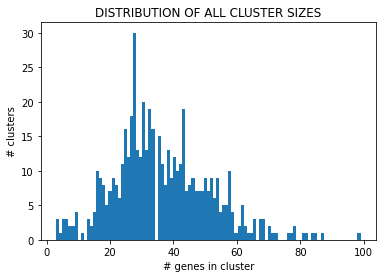

In [21]:
plt.hist(cluster_sizes, max(cluster_sizes))
plt.title('DISTRIBUTION OF ALL CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

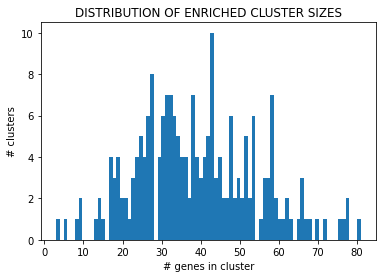

In [22]:
plt.hist(enriched_cluster_sizes, max(enriched_cluster_sizes))
plt.title('DISTRIBUTION OF ENRICHED CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

In [23]:
key_lens = [len(k) for k in partition_stats.keys()]
max_key_len = max(key_lens)

for k, v in partition_stats.items():
    print(f'{" " * (max_key_len - len(k))}{k}:', v)

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.016381816159012127
                  modularity: 0.7517050183899703
                   nclusters: 526
           mean_cluster_size: 36.4106463878327
         median_cluster_size: 34.0
             sd_cluster_size: 15.263795753314863
          nenriched_clusters: 204
  mean_enriched_cluster_size: 39.03431372549019
median_enriched_cluster_size: 38.0
    sd_enriched_cluster_size: 15.379633815332964
     nenriched_cluster_genes: 7963
                    datetime: 2024-05-03 16:02:37.754380


In [24]:
enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

In [25]:
outfile='../enrichment/test_nn3_full_enrichment.csv'
enrich_full_nn3.to_csv(outfile, index=False)

In [26]:
complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')

In [27]:
palette45 = """
#51635F\n#FF1C16\n#16FC26\n#403DFC\n#FE0DCE\n#F9AA00\n#00FFD5\n#22BFFE\n#BB3551\n#E6FE97\n#ECADFF\n#FFBFBD\n#CF00F5\n#0D8B00\n#D7FEFF\n#8D7200\n#F76C00\n#AD3288\n#5C5AB8\n#FC0080\n#B8FF16\n#00AAB4\n#FBE11C\n#9AAAD9\n#8BBB8C\n#934B47\n#6EFE99\n#9C6D91\n#FB9778\n#9D32AF\n#D40087\n#FFDC9D\n#FF8DB6\n#A96AFC\n#FDDDFB\n#168CF7\n#FD6CF9\n#F64553\n#4D6A00\n#FAFEDB\n#A7977D\n#0DFBFF\n#86B80D\n#FD8AE4\n#B7B126
""".split()

palette32 = """
white\n#F91622\n#16FC0D\n#5138FB\n#FD00CF\n#FDD51C\n#16FDD7\n#FC8B8E\n#16BFFF\n#DF9BFD\n#669C2A\n#FEE7C4\n#F31685\n#DF16FD\n#C1F1FE\n#A23D7E\n#D5FD0D\n#8C5A0D\n#FC790D\n#4F5CBC\n#FFCBEF\n#168D72\n#68FA93\n#C4FDC9\n#F7A449\n#16789B\n#AD0DAB\n#C4262E\n#0DF1FF\n#EFF994\n#B6C1FE\n#8F22CD
""".split()

palette35 = """
#585F6A\n#FE1626\n#00FB0D\n#2E40FC\n#FD0DCE\n#FCD200\n#F7868C\n#16FFDC\n#22BEFB\n#D28EF6\n#609000\n#FFE7C9\n#F51683\n#FF730D\n#CAFE16\n#AA3586\n#BEEEFD\n#BD00FA\n#895D22\n#FEC7F0\n#495AA1\n#73F995\n#229270\n#ED963B\n#F6FE97\n#C5FFD0\n#C50DC8\n#6993FF\n#C22A35\n#16ECFC\n#AA707E\n#7A3BCB\n#7C845C\n#358FAA\n#BDBAF6
""".split()

palette38 = """
#636265\n#F60D16\n#00F90D\n#3540FB\n#FD0DD0\n#FDDB0D\n#00FFE2\n#FA8884\n#2ABEFE\n#E5A3FF\n#518F00\n#FEFDD5\n#D51CFF\n#ED007F\n#A33879\n#96731C\n#C8FB16\n#C0ECFE\n#FBC1DA\n#5658BA\n#F96900\n#F69F1C\n#58FA9C\n#008E72\n#BA22B9\n#167D97\n#794D8A\n#CEFE9C\n#BB222E\n#954D45\n#00DCEF\n#FD66B0\n#B2FDD3\n#FDBD9F\n#A9B4F1\n#B371FE\n#849566\n#2A8EFF
""".split()

palette64 = """
white\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [28]:
palette36 = ["#FFFFFF", 
             "#E4E1E3", 
             "#F6222E", 
             "#FE00FA", 
             "#16FF32", 
             "#3283FE", 
             "#FEAF16", 
             "#B00068", 
             "#1CFFCE",
             "#90AD1C", 
             "#2ED9FF", 
             "#DEA0FD", 
             "#AA0DFE", 
             "#F8A19F", 
             "#325A9B", 
             "#C4451C", 
             "#1C8356", 
             "#85660D",
             "#B10DA1", 
             "#FBE426", 
             "#1CBE4F", 
             "#FA0087", 
             "#FC1CBF", 
             "#F7E1A0", 
             "#C075A6", 
             "#782AB6", 
             "#AAF400",
             "#BDCDFF", 
             "#822E1C", 
             "#B5EFB5", 
             "#7ED7D1", 
             "#1C7F93", 
             "#D85FF7", 
             "#683B79", 
             "#66B0FF", 
             "#3B00FB",
             "magenta"]

change index 5 to #778899. Change index 9 to #2F4F4F. Add #FF7F50. Change index 9 to #FFBCD9. Change index 14 to #DEA5A4

In [29]:
palette27 = ["#FFFFFF", 
             "#AA0DFE", 
             "#3283FE", 
             "#85660D", 
             "#782AB6", 
             "#778899", 
             "#1C8356", 
             "#16FF32", 
             "#F7E1A0", 
#              "#2F4F4F",
             "#FFBCD9", 
             "#C4451C", 
             "#DEA0FD", 
             "#FE00FA", 
#              "#325A9B", 
             "#FEAF16", 
             "#DEA5A4", 
             "#90AD1C", 
             "#F6222E",
             "#1CFFCE", 
             "#2ED9FF", 
             "#B10DA1", 
#              "#C075A6", 
#              "#FC1CBF", 
#              "#B00068", 
             "#FBE426", 
             "#FA0087",
             "#FF7F50"
            ]

In [30]:
with open(('colors_2000_1'), 'rb') as file:
    color_palette_raw = pickle.load(file)

color_palette = palette65

if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
    color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

In [31]:
import numpy as np
cols = full_filtered_norm_df.columns
np.min(full_filtered_norm_df[cols[1:]].values)

-6.202967337930747

In [32]:
# import numpy as np
# from bokeh.models import Button, ColumnDataSource, CustomJS
# from bokeh.plotting import Column, figure, show

# x = np.linspace(0, 20, 200)
# y = x**2

# source = ColumnDataSource(data=dict(x=x, y=y))

# p = figure(tools="xpan")
# p.line("x", "y", source=source)

# button = Button()
# button.js_on_click(
#     CustomJS(args={"xr": p.x_range, "yr": p.y_range, "source": source}, code="""
#         const i = Math.max(source.data.x.findIndex((x) => x > xr.start), 0)

#         const j0 = source.data.x.findIndex((x) => x > xr.end)
#         const j = j0 >= 0 ? j0 : source.data.x.length - 1

#         const ysub = source.data.y.slice(i, j)

#         yr.start = Math.min.apply(null, ysub);
#         yr.end = Math.max.apply(null, ysub);
#     """)
# )

# show(Column(p, button))

In [33]:
import os

embedding_metric='manhattan'

dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['microarr', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

p = bokeh_ui_utils.generate_and_save_umap(dashboard_path, full_filtered_norm_df, complete_annot, leiden_label_df_round_1_arranged_sorted, 'full', color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, n_neighbors=n_neighbors, embedding_metric=embedding_metric, z=True)

/Users/lmt/miniconda3/envs/cdh2.env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/lmt/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].values


./plots/dashboard40_microarr_umap_manhattan_3nn_0.005rp.html


In [34]:
mucocyst_cluster = [
'YF00036312.t1',
'YF00012829.t1',
'YF00000889.t1',
'TTHERM_00527180',
'TTHERM_00335830',
'YF00012830.t1',
'YF00009126.t1',
'YF00005954.t1',
'YF00005804.t1',
'TTHERM_01055600',
'TTHERM_00624720',
] # TTHERM_00630470: mucocyst gene with drastically different expression profile

In [35]:
print(','.join(mucocyst_cluster))

YF00036312.t1,YF00012829.t1,YF00000889.t1,TTHERM_00527180,TTHERM_00335830,YF00012830.t1,YF00009126.t1,YF00005954.t1,YF00005804.t1,TTHERM_01055600,TTHERM_00624720


In [36]:
clustering_utils.fraction_max_same_cluster_genes(mucocyst_cluster, leiden_label_df_round_1_arranged_sorted)

6 / 11 = 0.5454545454545454
             TTHERM_ID  label
15857    YF00012830.t1    241
15327    YF00009126.t1    241
14900    YF00005954.t1    241
14894    YF00005804.t1    241
13192  TTHERM_01055600    241
9825   TTHERM_00624720    241
YF00012830.t1,YF00009126.t1,YF00005954.t1,YF00005804.t1,TTHERM_01055600,TTHERM_00624720


0.5454545454545454